**Preprocessing**

In [1]:
import os, spacy

In [13]:
nlp = spacy.load("ru_core_news_lg")
nlp.max_length = 4000000

In [16]:
def lemmatize(filename, genre):

    with open('../datasets/' + genre + '/' + filename, 'r', encoding='utf-8') as f:
        lines = f.read()

    lemmas = []
    doc = nlp(lines, disable = ['ner', 'parser'])
    for token in doc:
        if token.lemma_.isalpha():
            lemmas.append(token.lemma_)

    path = '../datasets/lemmatized/' + genre
    if not os.path.exists(path):
        os.makedirs(path)

    with open(path + '/' + filename, 'w', encoding='utf-8') as f:
        f.write(' '.join(lemmas))

    return doc

In [ ]:
genres = ['ballads', 'elegies', 'songs', 'novels']

for genre in genres:

    filenames = os.listdir('../datasets/' + genre)

    for file in filenames:
        if file != '.DS_Store':
            spacy_doc = lemmatize(file, genre)

**TF-IDF**

using https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transfor
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

In [1]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

In [2]:
genres = ['ballads', 'elegies', 'songs', 'novels']
all_filenames_paths = []

for genre in genres:
    filenames = os.listdir('../datasets/lemmatized/' + genre)
    for file in filenames:
        all_filenames_paths.append('../datasets/lemmatized/' + genre + '/' + file)


vectorizer = TfidfVectorizer(input='filename', max_df=0.5, min_df=5)
X_tfidf = vectorizer.fit_transform(all_filenames_paths)

In [3]:
vectorizer.get_feature_names_out()

array(['ab', 'aber', 'absolument', ..., 'ён', 'ёрзать', 'ёрш'],
      dtype=object)

In [4]:
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 1827, n_features: 63331


In [5]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.030


In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 20.181 s
Explained variance of the SVD step: 29.6%


In [7]:
labels = [fname.split('/')[3] for fname in all_filenames_paths]

In [8]:
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

In [9]:
true_k

4

In [10]:
from collections import defaultdict
from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.05 ± 0.03 s 
Homogeneity: 0.729 ± 0.029
Completeness: 0.701 ± 0.019
V-measure: 0.715 ± 0.024
Adjusted Rand-Index: 0.714 ± 0.017
Silhouette Coefficient: 0.140 ± 0.001


In [12]:
kmeans.labels_

array([0, 3, 3, ..., 1, 1, 1], dtype=int32)

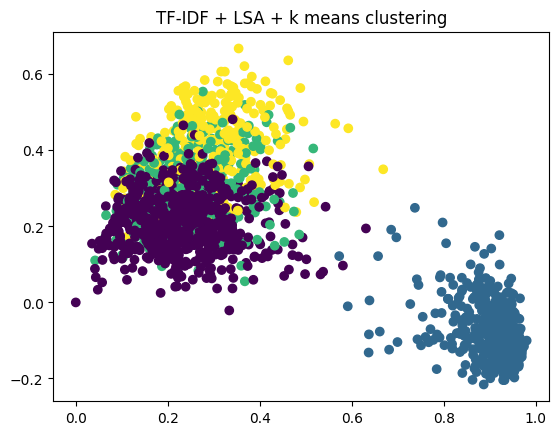

In [13]:
import matplotlib.pyplot as plt

x = X_lsa[:, 0]
y = X_lsa[:, 1]

plt.scatter(x, y, c=kmeans.labels_)
plt.title('TF-IDF + LSA + k means clustering')
plt.show()

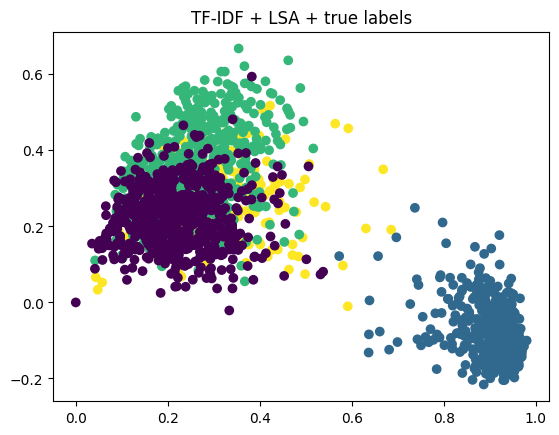

In [14]:
x = X_lsa[:, 0]
y = X_lsa[:, 1]

dict = {'ballads': 3,
        'elegies': 2,
        'songs': 0,
        'novels': 1}

int_true_labels = [dict[genre] for genre in labels]

plt.scatter(x, y, c=int_true_labels)
plt.title('TF-IDF + LSA + true labels')
plt.show()

In [41]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=true_k, assign_labels='discretize', n_neighbors=25).fit(X_lsa)
labels_predict=spectral.labels_.tolist()

In [42]:
from sklearn import metrics

print("Homogeneity:", metrics.homogeneity_score(labels, spectral.labels_))
print("Completeness:", metrics.completeness_score(labels, spectral.labels_))
print("V-measure:", metrics.v_measure_score(labels, spectral.labels_))
print("Adjusted Rand-Index:", metrics.adjusted_rand_score(labels, spectral.labels_))
print("Silhouette Coefficient:", metrics.silhouette_score(spectral.affinity_matrix_, spectral.labels_, sample_size=2000))

Homogeneity: 0.6083055181505426
Completeness: 0.5939944641293959
V-measure: 0.6010648184417181
Adjusted Rand-Index: 0.6203320003258375
Silhouette Coefficient: 0.10749655452382292


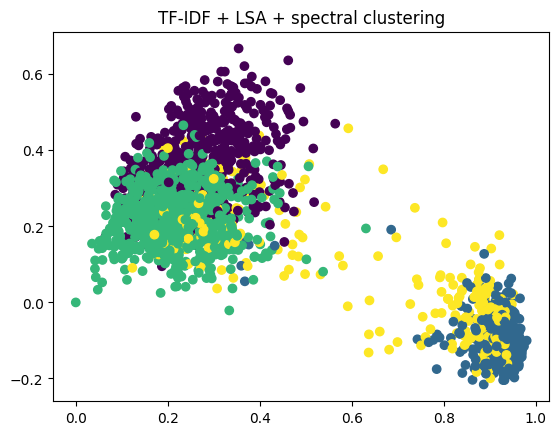

In [43]:
x = X_lsa[:, 0]
y = X_lsa[:, 1]

plt.scatter(x, y, c=spectral.labels_)
plt.title('TF-IDF + LSA + spectral clustering')
plt.show()

In [21]:
import pandas as pd

files = [fname.split('/')[4] for fname in all_filenames_paths]
data = {'file_names': files, 'genres': labels, 'lsa_tf_idf_labels': kmeans.labels_}
df = pd.DataFrame(data)

In [22]:
df

,file_names,genres,lsa_tf_idf_labels
0,175_1842_E.txt,ballads,2
1,47_1842_Lyubimov.txt,ballads,0
2,183_1844_Zhadovskaya.txt,ballads,0
3,157_1847_Nekrasov.txt,ballads,0
4,206_1841_Tolstoy.txt,ballads,0
...,...,...,...
1822,sukhonin.na_rubezhe_stoletiy.txt,novels,1
1823,boborykin.dolgo_li.txt,novels,1
1824,merder.vorotyntsevy.txt,novels,1
1825,dal.pavel_alekseyevich_igrivyy.txt,novels,1


In [23]:
df.to_csv('tfidf_genres.csv')

**TF-IDF based clustering with authors**

In [44]:
## getting authors

genres = ['ballads', 'elegies', 'songs', 'novels']
files = []
authors = []

for genre in genres:
    filenames = os.listdir('../datasets/lemmatized/' + genre)
    for file in filenames:

        if genre == 'novels':
            author = file.split('.')[0]
        elif genre == 'ballads':
            author = file.split('_')[2]
        else:
            author = file.split('_')[1]
    
        files.append(file)
        authors.append(author)    

In [45]:
files = []
authors = []

filenames = os.listdir('../datasets/lemmatized/novels/')
for file in filenames:

    if genre == 'novels':
        author = file.split('.')[0]
    elif genre == 'ballads':
        author = file.split('_')[2]
    else:
        author = file.split('_')[1]
    
    files.append(file)
    authors.append(author)   

In [46]:
print('n_files:', len(files))
print('n_all_authors:', len(authors))
print('n_unique_authors:', len(set(authors)))

n_files: 506
n_all_authors: 506
n_unique_authors: 153


In [47]:
from collections import Counter

Counter(authors).most_common(10)

[('leskov', 26),
 ('dostoyevskiy', 16),
 ('mamin_sibiryak', 16),
 ('turgenev', 15),
 ('stanyukovich', 14),
 ('pisemskiy', 13),
 ('tolstoy', 13),
 ('mordovtsev', 13),
 ('solovyevvs', 12),
 ('geyntse', 10)]

In [48]:
selected_authors = [i[0] for i in Counter(authors).most_common(10) if i[0] != 'Unknown']

In [49]:
true_authors = [author for author in authors if author in selected_authors]
indeces = [num for num, author in enumerate(authors) if author in selected_authors]
selected_files = [files[num] for num in indeces]

In [50]:
all_filenames_paths = ['../datasets/lemmatized/novels/' + file for file in selected_files]

vectorizer = TfidfVectorizer(input='filename', max_df=0.5, min_df=5)
X_tfidf = vectorizer.fit_transform(all_filenames_paths)

In [51]:
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 148, n_features: 30331


In [52]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 3.601 s
Explained variance of the SVD step: 85.2%


In [53]:
unique_labels, category_sizes = np.unique(true_authors, return_counts=True)
true_k = unique_labels.shape[0]

In [54]:
true_k

10

In [55]:
X_lsa.shape

(148, 100)

In [56]:
from collections import defaultdict
from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(true_authors, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(true_authors, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(true_authors, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(true_authors, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [57]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa)

clustering done in 0.01 ± 0.01 s 
Homogeneity: 0.280 ± 0.022
Completeness: 0.286 ± 0.025
V-measure: 0.283 ± 0.023
Adjusted Rand-Index: 0.095 ± 0.023
Silhouette Coefficient: 0.026 ± 0.002


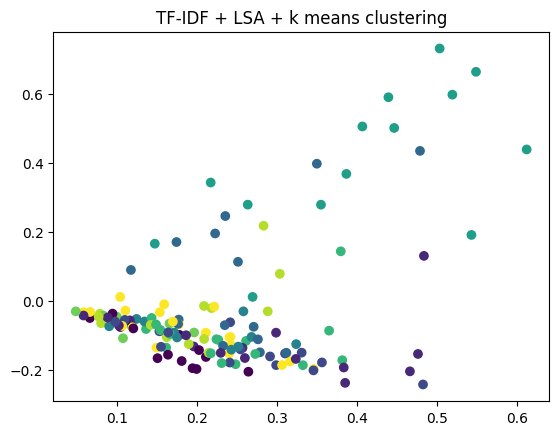

In [58]:
x = X_lsa[:, 0]
y = X_lsa[:, 1]

plt.scatter(x, y, c=kmeans.labels_)
plt.title('TF-IDF + LSA + k means clustering')
plt.show()

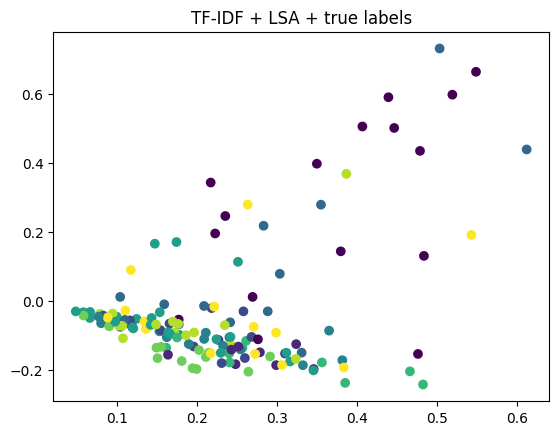

In [59]:
true_authors_dict = {}
i = 0
for author in true_authors:
    if author not in true_authors_dict:
        i += 1
        true_authors_dict[author] = i

x = X_lsa[:, 0]
y = X_lsa[:, 1]

plt.scatter(x, y, c=[true_authors_dict[author] for author in true_authors])
plt.title('TF-IDF + LSA + true labels')
plt.show()

In [60]:
spectral = SpectralClustering(n_clusters=true_k).fit(X_lsa)

In [61]:
print("Homogeneity:", metrics.homogeneity_score(true_authors, spectral.labels_))
print("Completeness:", metrics.completeness_score(true_authors, spectral.labels_))
print("V-measure:", metrics.v_measure_score(true_authors, spectral.labels_))
print("Adjusted Rand-Index:", metrics.adjusted_rand_score(true_authors, spectral.labels_))
print("Silhouette Coefficient:", metrics.silhouette_score(spectral.affinity_matrix_, spectral.labels_, sample_size=2000))

Homogeneity: 0.21854433141552965
Completeness: 0.37389213976605556
V-measure: 0.2758507002235153
Adjusted Rand-Index: 0.04970207900522076
Silhouette Coefficient: 0.11139768526355914


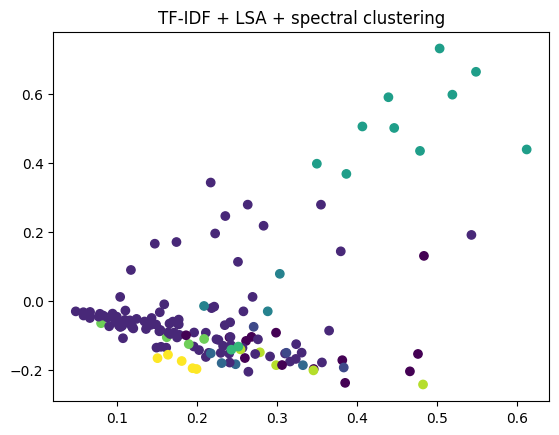

In [62]:
x = X_lsa[:, 0]
y = X_lsa[:, 1]

plt.scatter(x, y, c=spectral.labels_)
plt.title('TF-IDF + LSA + spectral clustering')
plt.show()